## Setup

In [1]:
from pathlib import Path
import os

# Define paths based on environment
if Path("/kaggle").exists():
    os.environ["AMBIENTE"] = "KAGGLE"
    os.environ["TENSORBOARD_NO_TF"] = "1"

    PATH_DATASET = Path("/kaggle/working/STROKE_PREDICTION")
    PATH_CODE = PATH_DATASET / "src"
    PATH_OUTPUT_DIR = PATH_DATASET / "outputs"
elif Path("/content").exists():
    os.environ["AMBIENTE"] = "COLAB"
    PATH_DATASET = Path("/content/DELETAR")
    PATH_CODE = PATH_DATASET / "src"
    PATH_OUTPUT_DIR = PATH_DATASET / "outputs"
else:
    os.environ["AMBIENTE"] = "LOCAL"
    PATH_CODE = Path.cwd()
    PATH_DATASET = PATH_CODE.parent
    PATH_OUTPUT_DIR = PATH_DATASET / "outputs"


# Check if installation has been done
INSTALL_MARKER = PATH_DATASET / ".install_complete"

try:
    if not INSTALL_MARKER.exists():
        # Install uv
        pass
        !pip install uv

        # Environment-specific setup
        if os.environ["AMBIENTE"] == "KAGGLE":
            import kaggle_secrets

            user_secrets = kaggle_secrets.UserSecretsClient()
            github_pat = user_secrets.get_secret("GITHUB_PAT")

            os.chdir("/kaggle/working")
            os.system(
                f"git clone -b class-imbalance https://{github_pat}@github.com/lfaoliveira/STROKE_PREDICTION.git"
            )
            os.chdir(PATH_DATASET)

        elif os.environ["AMBIENTE"] == "LOCAL":
            os.system("git pull origin main")

        # Install dependencies
        os.chdir(PATH_DATASET)
        os.system("uv pip install --requirements pyproject.toml --system")

        if os.environ["AMBIENTE"] == "KAGGLE":
            os.system(
                "uv pip install --upgrade --force-reinstall --no-cache-dir scipy numpy matplotlib protobuf tensorboard"
            )

        # Mark installation as complete
        INSTALL_MARKER.touch()
        print("Installation completed")
    else:
        print("Installation already completed, skipping...")

    os.chdir(PATH_CODE)
    print(f"Current working directory: {os.getcwd()}")
except Exception:
    print("FALHA AO INICIAR NOTEBOOK")

Installation already completed, skipping...
Current working directory: /kaggle/working/STROKE_PREDICTION/src


## Exploratory Data Analysis



DATASET:
          age  hypertension  heart_disease  avg_glucose_level       bmi  \
id                                                                        
77  -1.324241     -0.318067      -0.228208          -0.438884 -1.310695   
84   0.538054     -0.318067      -0.228208          -0.363242  0.331934   
91  -0.038371     -0.318067      -0.228208          -0.152525 -1.323428   
99  -0.526115     -0.318067      -0.228208           0.080704  2.980513   
129 -0.836497     -0.318067      -0.228208          -0.174588 -0.342945   

     gender_code  ever_married_code  work_type_code  Residence_type_code  \
id                                                                         
77     -0.833023          -1.370831        1.674998            -1.014569   
84      1.198428           0.729484       -0.155697             0.985640   
91     -0.833023          -1.370831       -0.155697             0.985640   
99     -0.833023          -1.370831       -0.155697             0.985640   
129    

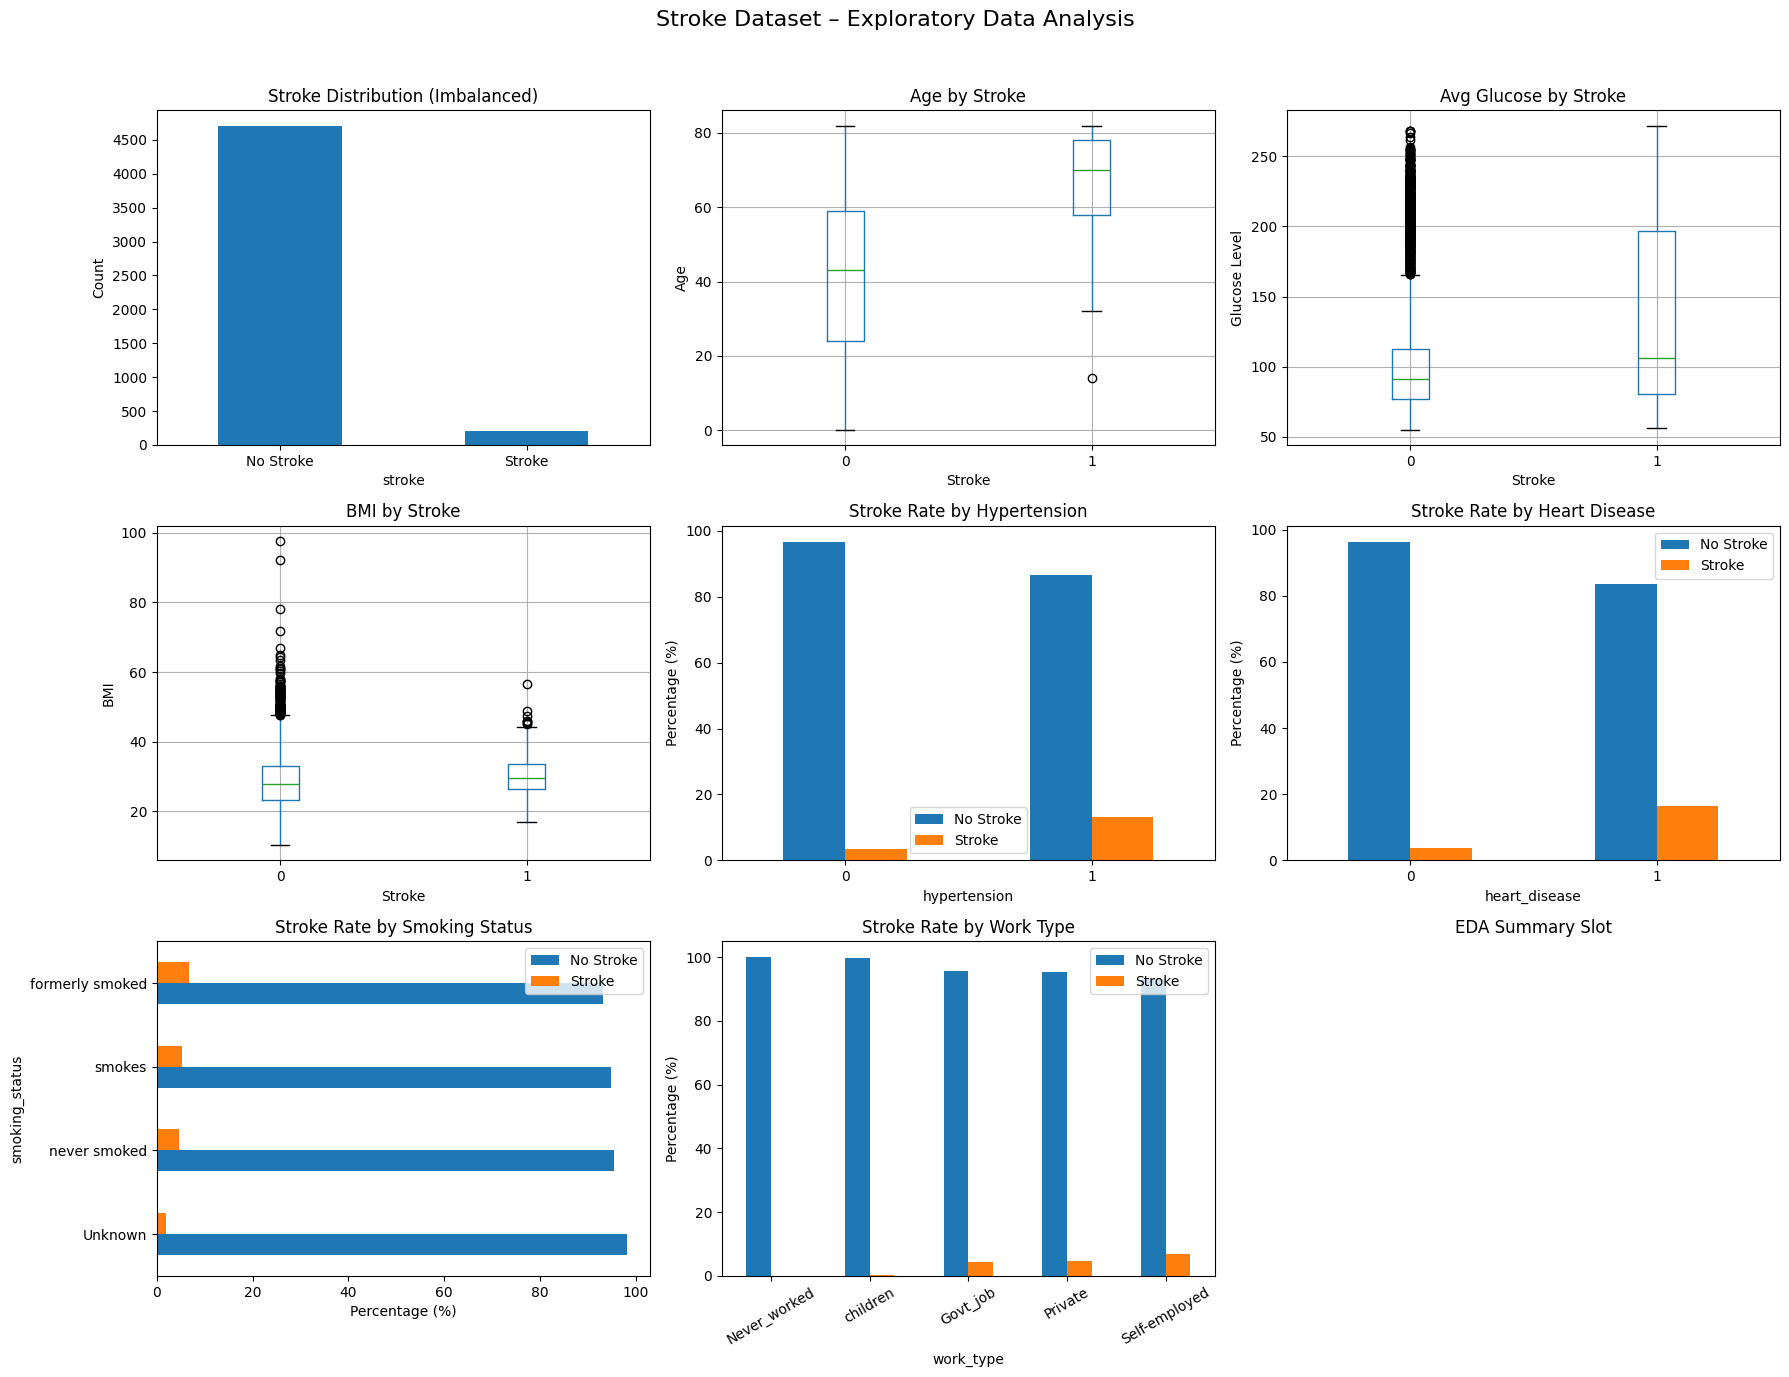

In [4]:
from DataProcesser.dataset import StrokeDataset
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Load data
# =========================
df = StrokeDataset().original_df.copy()

# =========================
# 1. Dataset overview
# =========================
print("Shape:", df.shape)
print(df.info())
print("\nMissing values:\n", df.isna().sum())

# =========================
# 2. Target distribution
# =========================
stroke_dist = df["stroke"].value_counts(normalize=True) * 100
print("\nStroke distribution (%):\n", stroke_dist)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# =========================
# 1. Stroke distribution
# =========================
df["stroke"].value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_title("Stroke Distribution (Imbalanced)")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["No Stroke", "Stroke"], rotation=0)
axes[0].set_ylabel("Count")
axes[0].set_yticks([i for i in range(0, 4501, 500)])
# =========================
# 2. Age vs Stroke
# =========================
df.boxplot(column="age", by="stroke", ax=axes[1])
axes[1].set_title("Age by Stroke")
axes[1].set_xlabel("Stroke")
axes[1].set_ylabel("Age")

# =========================
# 3. Glucose vs Stroke
# =========================
df.boxplot(column="avg_glucose_level", by="stroke", ax=axes[2])
axes[2].set_title("Avg Glucose by Stroke")
axes[2].set_xlabel("Stroke")
axes[2].set_ylabel("Glucose Level")

# =========================
# 4. BMI vs Stroke
# =========================
df.boxplot(column="bmi", by="stroke", ax=axes[3])
axes[3].set_title("BMI by Stroke")
axes[3].set_xlabel("Stroke")
axes[3].set_ylabel("BMI")

# =========================
# 5. Hypertension
# =========================
pd.crosstab(df["hypertension"], df["stroke"], normalize="index").mul(100).plot(
    kind="bar", ax=axes[4], rot=0
)
axes[4].set_title("Stroke Rate by Hypertension")
axes[4].set_ylabel("Percentage (%)")
axes[4].legend(["No Stroke", "Stroke"])

# =========================
# 6. Heart disease
# =========================
pd.crosstab(df["heart_disease"], df["stroke"], normalize="index").mul(100).plot(
    kind="bar", ax=axes[5], rot=0
)
axes[5].set_title("Stroke Rate by Heart Disease")
axes[5].set_ylabel("Percentage (%)")
axes[5].legend(["No Stroke", "Stroke"])

# =========================
# 7. Smoking status
# =========================
pd.crosstab(df["smoking_status"], df["stroke"], normalize="index").mul(100).sort_values(
    by=1
).plot(kind="barh", ax=axes[6])
axes[6].set_title("Stroke Rate by Smoking Status")
axes[6].set_xlabel("Percentage (%)")
axes[6].legend(["No Stroke", "Stroke"])

# =========================
# 8. Work type
# =========================
pd.crosstab(df["work_type"], df["stroke"], normalize="index").mul(100).sort_values(
    by=1
).plot(kind="bar", ax=axes[7], rot=30)
axes[7].set_title("Stroke Rate by Work Type")
axes[7].set_ylabel("Percentage (%)")
axes[7].legend(["No Stroke", "Stroke"])

# =========================
# 9. Empty / summary slot
# =========================
axes[8].axis("off")
axes[8].set_title("EDA Summary Slot")

plt.suptitle("Stroke Dataset – Exploratory Data Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Training with Optuna

In [ ]:
import gc
from pathlib import Path
import pandas as pd
import torch
import os
from typing import Callable, Literal
from IPython.display import clear_output
import logging

from Models.mlp import MLP, MLPSearchSpace
from lightning import Callback, seed_everything, Trainer
from lightning.pytorch.loggers import MLFlowLogger
import mlflow
from mlflow.pytorch import autolog
from DataProcesser.datamodule import StrokeDataModule
import optuna
from Models.kan import KANSearchSpace, MyKan
from lightning.pytorch.callbacks import EarlyStopping
from tqdm.auto import tqdm


# ---------------------------------------------------------------------------
# Utilities
# ---------------------------------------------------------------------------


def hard_delete_optuna(
    code_path: Path = PATH_CODE,
    output_path: Path = PATH_OUTPUT_DIR,
):
    import shutil

    deleted_items = []
    # Full cleanup - remove everything
    db_path = code_path / "mlflow.db"
    if db_path.exists():
        os.remove(db_path)
        deleted_items.append(f"Database: {db_path}")

    mlruns_path = code_path / "mlruns"
    if mlruns_path.exists():
        shutil.rmtree(mlruns_path)
        deleted_items.append(f"MLruns folder: {mlruns_path}")

    artifacts_dir = output_path / "artifacts"
    if artifacts_dir.exists():
        shutil.rmtree(artifacts_dir)
        deleted_items.append(f"Artifacts: {artifacts_dir}")

    best_runs_csv = output_path / "best_optuna_runs.csv"
    if best_runs_csv.exists():
        os.remove(best_runs_csv)
        deleted_items.append(f"Best runs CSV: {best_runs_csv}")


def clear_optuna_bad_trainings(
    output_path: Path = PATH_OUTPUT_DIR,
    preserve_optuna: bool = True,
    verbose: bool = True,
    best_runs: list[str] | None = None,
) -> None:
    """
    Clears MLflow and training artifacts.

    Args:
        code_path: Path to the code directory containing mlflow.db
        output_path: Path to the outputs directory
        preserve_optuna: If True, keeps only essential Optuna results (mlflow.db and outputs folder).
                        If False, performs full cleanup including MLflow database.
        verbose: Whether to print deletion messages

    When preserve_optuna=True (safe for post-Optuna cleanup):
        - Keeps: mlflow.db (contains all trial data)
        - Keeps: mlruns folder
        - Keeps: outputs folder structure and best_optuna_runs.csv
        - Keeps: Best run's artifacts for each model
        - Deletes: Trial CSV files in outputs/artifacts/ (except best runs)

    When preserve_optuna=False (full cleanup):
        - Removes everything: mlflow.db, mlruns/, outputs/artifacts/, best_optuna_runs.csv
    """

    assert best_runs is not None
    deleted_items = []

    if preserve_optuna:
        # Delete trial CSV files in artifacts directory, but keep best run artifacts
        artifacts_dir = output_path / "artifacts"
        if artifacts_dir.exists():
            csv_files = list(artifacts_dir.glob("test_results_*.csv"))
            for csv_file in csv_files:
                # Extract run_id from filename: test_results_<run_id>.csv
                run_id = csv_file.stem.replace("test_results_", "")
                if run_id not in best_runs:
                    os.remove(csv_file)
                    deleted_items.append(f"Trial artifact: {csv_file.name}")
                elif verbose:
                    print(f"  ↷ Keeping best run artifact: {csv_file.name}")

    if verbose:
        mode = (
            "preserving best results (mlflow.db + outputs)"
            if preserve_optuna
            else "full cleanup"
        )
        print(f"Running {mode}...")
        if deleted_items:
            print("Successfully deleted:")
            for item in deleted_items:
                print(f"  {item}")
        else:
            print("No training artifacts found to delete.")
    else:
        print("Running Cleanup...")

    return


def supress_warnings():
    logging.getLogger("mlflow.utils.requirements_utils").setLevel(logging.ERROR)
    logging.getLogger("mlflow").setLevel(logging.ERROR)
    logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.ERROR)
    optuna.logging.set_verbosity(optuna.logging.WARNING)


def model_choice(
    choice: str,
    input_dims: int,
    trial: optuna.trial.Trial,
    n_classes: int,
    recall_factor: list[float],
):
    if choice == "MLP":
        search_space = MLPSearchSpace()
        suggested_hparams = search_space.suggest_optuna(trial)
        model = MLP(
            input_dims,
            n_classes,
            recall_factor=recall_factor,
            hyperparameters=suggested_hparams,
        )
        return model, suggested_hparams, search_space.Keys
    elif choice == "KAN":
        search_space = KANSearchSpace()
        suggested_hparams = search_space.suggest_optuna(trial)
        model = MyKan(
            input_dims,
            n_classes,
            recall_factor=recall_factor,
            hyperparameters=suggested_hparams,
        )
        return model, suggested_hparams, search_space.Keys
    else:
        raise ValueError(f"Invalid model choice: {choice}")


# ---------------------------------------------------------------------------
# Extracted helpers
# ---------------------------------------------------------------------------


def _build_trainer(
    gpu: bool,
    epochs: int,
    patience: int,
    mlflow_logger: MLFlowLogger,
    early_stop: bool = True,
) -> Trainer:
    callbacks: list[Callback] | None = (
        [EarlyStopping(monitor="val_loss", patience=patience, mode="min")]
        if early_stop
        else None
    )
    return Trainer(
        max_epochs=epochs,
        devices=1,
        accelerator="gpu" if gpu else "cpu",
        num_nodes=1,
        logger=mlflow_logger,
        enable_checkpointing=False,
        enable_model_summary=False,
        enable_progress_bar=False,
        log_every_n_steps=None,
        callbacks=callbacks,
    )


def _test_and_log_artifacts(
    model,
    datamodule: StrokeDataModule,
    batch_size: int,
    run: mlflow.ActiveRun,
    artifact_path: Path,
) -> None:
    """Run the test step, log metrics and save the predictions CSV as an MLflow artifact."""
    test_df = datamodule.dataset.original_df.copy()
    test_df["pred"] = None
    test_df["error"] = None

    _, test_dataset = datamodule.test_dataloader(batch_size)
    return_dict = model.test_step(test_dataset=test_dataset, output_df=test_df)
    test_df = return_dict["output_df"]

    test_results = model.test_metrics.compute()
    mlflow.log_metrics(
        {f"test_{k}": float(v) for k, v in test_results.items() if v.numel() == 1}
    )
    model.test_metrics.reset()

    path_test_csv = artifact_path / f"test_results_{run.info.run_id}.csv"
    if path_test_csv.exists() and path_test_csv.is_dir():
        import shutil

        shutil.rmtree(path_test_csv)
    print(f"CSV: {path_test_csv}")

    test_df.to_csv(path_test_csv)
    assert path_test_csv.exists(), f"CSV not found at {path_test_csv}"
    mlflow.log_artifact(str(path_test_csv))


def _tag_best_run(exp_name: str, prefix: str) -> str :
    """Find the trial with the lowest val_loss and attach a human-readable name tag. Also appends choice and best run_id to csv"""
    experiment = mlflow.get_experiment_by_name(exp_name)
    if not experiment:
        return ""

    output_filename = os.environ["OPTUNA_BEST_RUN_CSV"]

    runs_df = pd.DataFrame(
        mlflow.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["metrics.val_loss ASC"],
        )
    ).dropna(subset=["metrics.val_loss"])

    if runs_df.empty:
        raise RuntimeError(f"No runs with val_loss found for experiment '{exp_name}'")

    best_run_id = str(runs_df.iloc[0].run_id)
    choice = exp_name.split("_")[1]
    print(f"BEST ID: {best_run_id} for {choice} model")
    mlflow.MlflowClient().set_tag(best_run_id, "mlflow.runName", f"{prefix}_{choice}")
    with open(output_filename, "a") as f:
        f.write(f"{choice},{best_run_id}\n")

    return best_run_id


def _run_optuna_study(
    objective: Callable,
    n_trials: int,
    study_name: str,
    parent_run: mlflow.ActiveRun,
) -> optuna.Study:
    """Create the Optuna study, optimise, and log summary metrics to the parent run."""
    study = optuna.create_study(direction="minimize", study_name=study_name)
    study.optimize(objective, n_trials=n_trials, gc_after_trial=True)

    mlflow.log_params(
        {"best_" + k: v for k, v in study.best_trial.params.items()},
        run_id=parent_run.info.run_id,
    )
    mlflow.log_metric(
        "best_val_loss",
        study.best_trial.value or float("inf"),
        run_id=parent_run.info.run_id,
    )
    mlflow.log_params(
        {"best_trial_id": study.best_trial.user_attrs.get("run_id")},
        run_id=parent_run.info.run_id,
    )

    print("Best hyperparameters:", study.best_trial.params)
    print("Best validation loss:", study.best_trial.value)
    return study


def _make_objective(
    choice: str,
    input_dims: int,
    n_classes: int,
    datamodule: StrokeDataModule,
    exp_name: str,
    mlf_track_uri: str,
    gpu: bool,
    epochs: int,
    patience: int,
    artifact_path: Path,
    pbar: tqdm,
):
    """Factory method - returns the Optuna objective closure with all context captured."""

    def objective(trial: optuna.Trial) -> float:
        model, hyperparameters, keys = model_choice(
            choice, input_dims, trial, n_classes, datamodule.class_weights
        )
        batch_size = hyperparameters[keys.BATCH_SIZE]

        train_loader = datamodule.train_dataloader(batch_size)
        val_loader = datamodule.val_dataloader(batch_size)
        _ = model(model.example_input_array)

        with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True) as run:
            mlflow_logger = MLFlowLogger(
                experiment_name=exp_name,
                tracking_uri=mlf_track_uri,
                log_model=True,
                run_id=run.info.run_id,
            )
            trainer = _build_trainer(gpu, epochs, patience, mlflow_logger)
            trainer.fit(
                model, train_dataloaders=train_loader, val_dataloaders=val_loader
            )
            mlflow.log_params(dict(model.hparams))
            val_loss = trainer.callback_metrics["val_loss"].item()

            _test_and_log_artifacts(model, datamodule, batch_size, run, artifact_path)

        torch.cuda.empty_cache()
        pbar.update(1)
        pbar.set_postfix({"val_loss": f"{val_loss:.4f}", "trial": trial.number})
        return val_loss

    return objective


# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------


def main(CHOICE: str, MLF_TRACK_URI: str):
    seed_everything(42)
    supress_warnings()

    GPU = os.environ["AMBIENTE"] in ["KAGGLE", "COLAB"]
    WORKERS = os.cpu_count() or 1
    BATCH_SIZE = 32
    EPOCHS = 20
    TRIALS = 20
    PATIENCE = 25
    ARTIFACT_PATH = PATH_OUTPUT_DIR / "artifacts"
    os.makedirs(ARTIFACT_PATH, exist_ok=True)

    EXP_NAME = f"stroke_{CHOICE}_1"
    mlflow.set_tracking_uri(MLF_TRACK_URI)
    mlflow.set_experiment(EXP_NAME)
    autolog(log_models=True, checkpoint=True, exclusive=False)

    datamodule = StrokeDataModule(BATCH_SIZE, WORKERS)
    datamodule.prepare_data()
    datamodule.setup("fit")
    INPUT_DIMS = datamodule.input_dims or -1
    assert INPUT_DIMS > 0

    pbar = tqdm(
        total=TRIALS, desc=f"({CHOICE}) trials", position=0, leave=True, colour="green"
    )

    objective = _make_objective(
        choice=CHOICE,
        input_dims=INPUT_DIMS,
        n_classes=2,
        datamodule=datamodule,
        exp_name=EXP_NAME,
        mlf_track_uri=MLF_TRACK_URI,
        gpu=GPU,
        epochs=EPOCHS,
        patience=PATIENCE,
        artifact_path=ARTIFACT_PATH,
        pbar=pbar,
    )
    best_run_id = None
    with mlflow.start_run(run_name=None) as parent_run:
        _run_optuna_study(objective, TRIALS, CHOICE, parent_run)
        pbar.close()

        best_run_id = _tag_best_run(EXP_NAME, os.environ["OPTUNA_BEST_RUN_PREFIX"])
    return best_run_id


if __name__ == "__main__":
    try:
        ARQ_TYPE = Literal["MLP", "KAN", "SVM", "XGBOOST", "RNDFOREST", "LIQUIDNN"]
        models: list[ARQ_TYPE] = ["MLP", "KAN"]
        MLF_TRACK_URI = f"sqlite:///{PATH_CODE}/mlflow.db"

        os.environ["OPTUNA"] = "True"
        os.environ["OPTUNA_BEST_RUN_PREFIX"] = "best_run"
        best_runs_csv = PATH_OUTPUT_DIR / "best_optuna_runs.csv"
        os.environ["OPTUNA_BEST_RUN_CSV"] = str(best_runs_csv)

        supress_warnings()
        best_runs = []
        for choice in models:
            best_run_id = main(choice, MLF_TRACK_URI)
            best_runs.append(best_run_id)
            clear_output(wait=True)

        clear_optuna_bad_trainings(best_runs=best_runs)

    except KeyboardInterrupt:
        print("PREMATURELY INTERRUPTING...\n")
    except Exception as e:
        raise e
    gc.collect()


## Normal training

In [ ]:
from pathlib import Path
import os
from typing import Any, Literal
import logging

import gc
import mlflow
import torch
from Models.mlp import MLP, MLPSearchSpace
from Models.kan import MyKan, KANSearchSpace
from lightning import seed_everything, Trainer
from lightning.pytorch.loggers import MLFlowLogger
from mlflow.pytorch import autolog
from lightning.pytorch.callbacks import EarlyStopping
from DataProcesser.datamodule import StrokeDataModule
import pandas as pd


def get_best_hyperparameters_from_optuna(choice: str, mlf_track_uri: str) -> dict:
    """
    Reads the best run ID from the CSV file saved during Optuna training,
    fetches the run from MLflow, and returns the hyperparameters as a dict.
    
    Args:
        choice: Model architecture name (e.g., "MLP", "KAN")
        mlf_track_uri: MLflow tracking URI
        
    Returns:
        Dictionary of hyperparameters from the best Optuna run (with string keys)
    """
    
    csv_path = os.environ.get("OPTUNA_BEST_RUN_CSV", "best_optuna_run.csv")
    if not csv_path or not Path(csv_path).exists():
        raise FileNotFoundError(f"Optuna best runs CSV not found at {csv_path}")
    
    # Read CSV and find the row matching the current choice
    df = pd.read_csv(csv_path, header=None, names=["model", "run_id"])
    matching_rows = df[df["model"] == choice]
    
    if matching_rows.empty:
        raise ValueError(f"No best run found for model '{choice}' in {csv_path}")
    
    best_run_id = matching_rows.iloc[0]["run_id"]
    
    # Fetch the run from MLflow
    mlflow.set_tracking_uri(mlf_track_uri)
    run = mlflow.get_run(best_run_id)
    
    # Extract parameters
    hyperparameters = dict(run.data.params)
    
    # Convert numeric strings back to appropriate types
    for key, value in hyperparameters.items():
        try:
            # Try integer conversion first
            hyperparameters[key] = int(value)
        except ValueError:
            try:
                # Try float conversion
                hyperparameters[key] = float(value)
            except ValueError:
                # Keep as string
                pass
    
    print(f"{choice} STORED HYPERPARMS: {hyperparameters}\n")
    return hyperparameters


def zip_res(
    path_sqlite: str,
    path_mlflow: Path,
    outputs_path: Path,
    filename: str,
    dest_folder: Path | None = None,
):
    import shutil

    path_sqlite_clean = path_sqlite.replace("sqlite:///", "")
    print(f"CWD: {Path.cwd()}\n")
    PATH_TEMP = Path.cwd() / "ZIP_TEMP"
    shutil.rmtree(PATH_TEMP, ignore_errors=True)
    PATH_TEMP.mkdir(parents=True, exist_ok=True)

    shutil.copy(path_sqlite_clean, PATH_TEMP / Path(path_sqlite_clean).name)
    shutil.copytree(path_mlflow, PATH_TEMP / path_mlflow.name)
    shutil.copytree(outputs_path, PATH_TEMP / outputs_path.name)

    # Determine destination folder
    if dest_folder is None:
        dest_folder = Path.cwd()
    else:
        dest_folder.mkdir(parents=True, exist_ok=True)

    # Create zip file in destination folder
    zip_path = dest_folder / filename.replace(".zip", "")
    shutil.make_archive(str(zip_path), "zip", PATH_TEMP)
    shutil.rmtree(PATH_TEMP)
    print(f"PATH ZIPFILE: {zip_path.with_suffix('.zip').resolve()}")


def supress_warnings():
    # Suppress specific MLflow warnings
    logging.getLogger("mlflow.utils.requirements_utils").setLevel(logging.ERROR)
    logging.getLogger("mlflow").setLevel(logging.ERROR)

    # Suppress PyTorch Lightning info messages
    logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.ERROR)


def model_choice(CHOICE, INPUT_DIMS, N_CLASSES, recall_factor: list[float], optuna_hyperparams: dict[str, float|int] = {}):
    if CHOICE == "MLP":
        search_space = MLPSearchSpace()

        keys = search_space.Keys
        hyperparams = {
            keys.BATCH_SIZE: 32,
            keys.HIDDEN_DIMS: 512,
            keys.LR: 2e-7,
            keys.WEIGHT_DECAY: 1e-5,
            keys.BETA0: 0.99,
            keys.BETA1: 0.999,
            keys.N_LAYERS: 80,
        }
        
        # Map optuna hyperparams (string keys) to Keys enum
        if optuna_hyperparams:
            mapped_hyperparams = {}
            for key_enum, default_value in hyperparams.items():
                # Get the string representation of the enum key
                key_str = key_enum.value
                if key_str in optuna_hyperparams:
                    mapped_hyperparams[key_enum] = optuna_hyperparams[key_str]
                else:
                    mapped_hyperparams[key_enum] = default_value
            hyperparams = mapped_hyperparams
        
        print(f"MLP HYPERPARAMS: {hyperparams}")
        suggested_hparams = search_space.suggest(hyperparams)
        model = MLP(
            INPUT_DIMS,
            N_CLASSES,
            recall_factor=recall_factor,
            hyperparameters=suggested_hparams,
        )
    elif CHOICE == "KAN":
        search_space = KANSearchSpace()
        keys = search_space.Keys
        hyperparams = {
            keys.BATCH_SIZE: 32,
            keys.HIDDEN_DIMS: 100,
            keys.LR: 2e-7,
            keys.WEIGHT_DECAY: 1e-5,
            keys.BETA0: 0.99,
            keys.BETA1: 0.999,
            keys.GRID: 184,
            keys.SPLINE_POL_ORDER: 4,
        }
        
        # Map optuna hyperparams (string keys) to Keys enum
        if optuna_hyperparams:
            mapped_hyperparams = {}
            for key_enum, default_value in hyperparams.items():
                # Get the string representation of the enum key
                key_str = key_enum.value
                if key_str in optuna_hyperparams:
                    mapped_hyperparams[key_enum] = optuna_hyperparams[key_str]
                else:
                    mapped_hyperparams[key_enum] = default_value
            hyperparams = mapped_hyperparams
        
        print(f"KAN HYPERPARAMS: {hyperparams}")
        suggested_hparams = search_space.suggest(hyperparams)
        model = MyKan(
            INPUT_DIMS,
            N_CLASSES,
            recall_factor=recall_factor,
            hyperparameters=suggested_hparams,
        )
    else:
        raise ValueError("ESCOLHA DE MODELO ERRADA!")
    return model, suggested_hparams, keys


## -----------------------------COLAR NO KAGGLE------------------
def main(CHOICE: str):
    ###------SEEDS---------###
    RAND_SEED = 42
    seed_everything(RAND_SEED)
    supress_warnings()

    AMBIENTE = os.environ["AMBIENTE"]
    GPU = True if AMBIENTE in ["KAGGLE", "COLAB"] else False
    ## ----------VARIAVEIS TREINO-----------
    cpus = os.cpu_count()
    WORKERS = cpus if cpus is not None else 1
    NUM_DEVICES = 1 if GPU else 1
    NUM_NODES = 1
    BATCH_SIZE = 32
    EPOCHS =75
    PATIENCE = int(EPOCHS * 0.6)
    ARTIFACT_PATH = PATH_OUTPUT_DIR / "artifacts"
    os.makedirs(ARTIFACT_PATH, exist_ok=True)

    #### -------- VARIAVEIS DE LOGGING ------------
    EXP_NAME = f"stroke_{CHOICE}_1"
    RUN_NAME: str | None = f"normal_{CHOICE}"
    MLF_TRACK_URI = f"sqlite:///{PATH_CODE}/mlflow.db"

    mlflow.set_tracking_uri(MLF_TRACK_URI)
    mlflow.set_experiment(EXP_NAME)
    autolog(log_models=True, checkpoint=True, exclusive=False)

    hyperparams = get_best_hyperparameters_from_optuna(CHOICE, MLF_TRACK_URI)

    ## ----------VARIAVEIS MODELO-----------
    N_CLASSES = 2

    datamodule = StrokeDataModule(BATCH_SIZE, WORKERS)
    datamodule.prepare_data()
    datamodule.setup("fit")

    INPUT_DIMS = datamodule.input_dims or -1
    assert INPUT_DIMS > 0
    recall_factor = datamodule.class_weights
    model, _, keys = model_choice(CHOICE, INPUT_DIMS, N_CLASSES, recall_factor, optuna_hyperparams=hyperparams)

    _ = model(model.example_input_array)

    # loop principal de treinamento
    with mlflow.start_run(run_name=RUN_NAME) as run:
        active_run_id = run.info.run_id

        mlflow_logger = MLFlowLogger(
            experiment_name=EXP_NAME,
            tracking_uri=MLF_TRACK_URI,
            log_model=True,
            run_id=active_run_id,
        )

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=PATIENCE, mode="min"
        )

        trainer = Trainer(
            max_epochs=EPOCHS,
            devices=NUM_DEVICES,
            accelerator="gpu" if GPU else "cpu",
            num_nodes=NUM_NODES,
            logger=mlflow_logger,
            enable_checkpointing=False,
            callbacks=[early_stopping],
        )
        trainer.fit(model, datamodule=datamodule)
        mlflow.log_params(dict(model.hparams))

        # Test and log artifacts (useful for the Analysis section)
        test_df = datamodule.dataset.original_df.copy()
        test_df["pred"] = None
        test_df["error"] = None

        # Perform one-pass test logic on the full test dataset
        _, test_dataset = datamodule.test_dataloader()
        return_dict = model.test_step(
            test_dataset=test_dataset,
            output_df=test_df,
        )
        test_df = return_dict["output_df"]

        # Log test metrics to MLFlow
        test_results = model.test_metrics.compute()
        mlflow.log_metrics(
            {f"test_{k}": float(v) for k, v in test_results.items() if v.numel() == 1}
        )
        model.test_metrics.reset()

        name = f"test_results_{run.info.run_id}.csv"
        path_test_csv = Path(ARTIFACT_PATH, name)
        test_df.to_csv(path_test_csv)
        mlflow.log_artifact(str(path_test_csv))

        torch.cuda.empty_cache()

    return


if __name__ == "__main__":
    try:
        ARQ_TYPE = Literal["MLP", "KAN", "SVM", "XGBOOST"]  ## MODEL ARCHITECTURE
        models: list[ARQ_TYPE] = ["MLP", "KAN"]
        for choice in models:
            # trains model based on architecture
            main(choice)
 
        NAME_RESZIP = "resultado_kaggle_stroke_normal"
        MLRUNS_FOLDER = Path.cwd() / "mlruns"
        MLF_TRACK_URI = f"sqlite:///{PATH_CODE}/mlflow.db"
        ZIP_ROOT = (
            PATH_DATASET / ".." if os.environ["AMBIENTE"] == "KAGGLE" else PATH_DATASET
        )

        zip_res(MLF_TRACK_URI, MLRUNS_FOLDER, PATH_OUTPUT_DIR, NAME_RESZIP, ZIP_ROOT)
        print("\n", "=" * 60)
        print(f"RESULTADOS ZIPADOS {Path(ZIP_ROOT, NAME_RESZIP).resolve()}")
        print("=" * 60, "\n")

    except Exception as e:
        raise e
    gc.collect()

    if os.environ["AMBIENTE"] == "LOCAL":
        from view.dashboard import see_model

        see_model(PATH_DATASET / "mlflow.db", PATH_DATASET / ".." / "mlruns")


: 

: 

In [ ]:
import gc
gc.collect()

: 

: 

## Results Graphs

c:\Users\LUIS FELIPE\Desktop\PROJETO_PESS_DADOS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026/02/18 12:11:28 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/18 12:11:28 INFO mlflow.store.db.utils: Updating database tables
2026/02/18 12:11:28 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/18 12:11:28 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/18 12:11:28 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/18 12:11:28 INFO alembic.runtime.migration: Will assume non-transactional DDL.


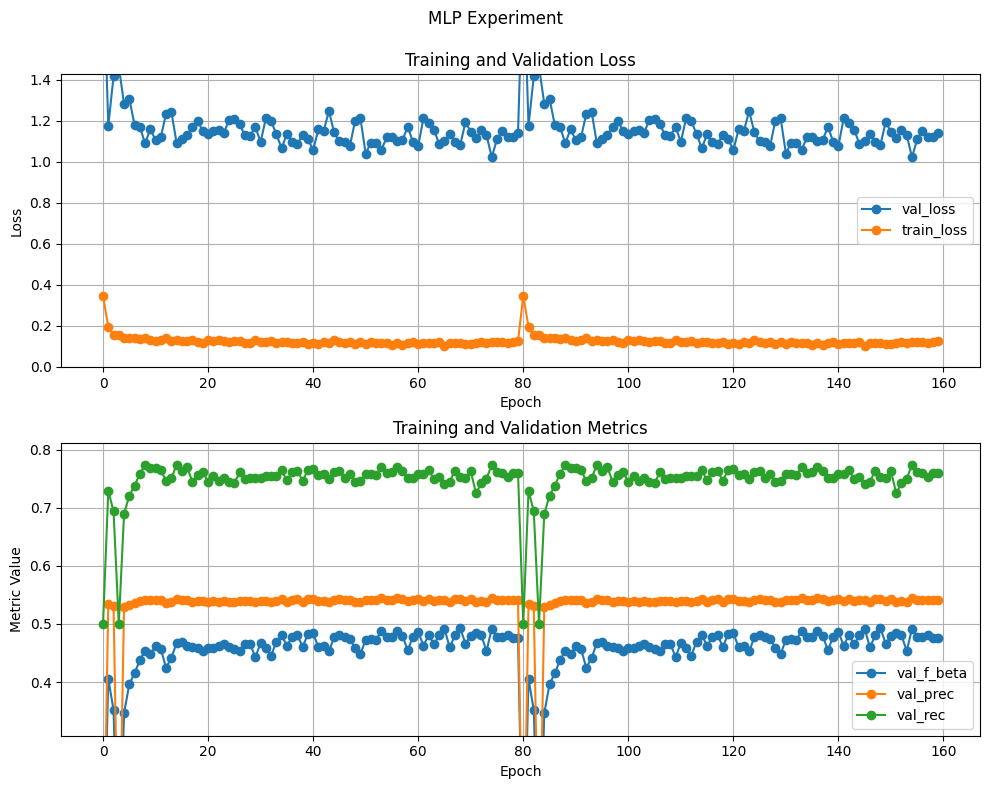

Artifact 'test_results_303aa926214b479da1dcc1f114c24da4.csv' not found in run 303aa926214b479da1dcc1f114c24da4


Exception: ARTIFACT NOT FOUND!

In [2]:
import mlflow
from typing import Literal
from DataProcesser.utils import final_analysis

# Saves directly to env output dir
output_dir = PATH_OUTPUT_DIR
if os.environ["AMBIENTE"] == "KAGGLE":
    output_dir = PATH_OUTPUT_DIR / "artifacts"


# Set MLflow tracking URI
mlflow.set_tracking_uri(f"sqlite:///{PATH_CODE}/mlflow.db")
ARQ_TYPE = Literal["MLP", "KAN", "SVM", "XGBOOST"]  ## MODEL ARCHITECTURE
models: list[ARQ_TYPE] = ["MLP", "KAN"]
# os.environ["OPTUNA"] = "True"

SORT_METRIC = "val_f_beta_avg"
RESIDUAL = True
unwanted_metrics = ["epoch", "step", "test"]
compare_df, resProcesser = final_analysis(
    models, output_dir, SORT_METRIC, unwanted_metrics, residual=RESIDUAL
)

compare_df.to_csv(output_dir / "classify_results.csv")
print(compare_df.to_string())

ser_fbeta = compare_df[SORT_METRIC].sort_values(ascending=False)
best_model, fbeta_value = next(ser_fbeta.items())
print(f"BEST MODEL: *{best_model}* WITH F-BETA: {fbeta_value}\n")

# If true, execute residual analysis of best model's errors
if RESIDUAL and False:
    resProcesser.fit_predict(str(best_model))
    pass


## Clear previous trainings

In [ ]:
import shutil
import os
import gc

# Define paths to MLflow storage
db_path = PATH_CODE / "mlflow.db"
mlruns_path = PATH_CODE / "mlruns"
artifacts_dir = PATH_OUTPUT_DIR / "artifacts"

# Remove MLflow database file
if db_path.exists():
    os.remove(db_path)
    print(f"Deleted database: {db_path}")

# Remove MLflow artifacts directory
if mlruns_path.exists():
    shutil.rmtree(mlruns_path)
    print(f"Deleted artifacts folder: {mlruns_path}")

# Remove custom artifacts directory (CSVs generated during training)
if artifacts_dir.exists():
    shutil.rmtree(artifacts_dir)
    print(f"Deleted custom artifacts: {artifacts_dir}")

gc.collect()

## MLFlow's Dashboard (Only works outside of Kaggle)
### Download the training results from Kaggle and paste them into a cloned folder of the repository

In [ ]:
import shutil
import subprocess
from pathlib import Path
import pathlib


def see_model(database: pathlib.Path, folder: pathlib.Path):
    subprocess.Popen(
        [
            "mlflow",
            "ui",
            "--backend-store-uri",
            f"sqlite:///{database}",
            "--default-artifact-root",
            folder,
            "--host",
            "127.0.0.1",
            "--port",
            "5000",
        ]
    )


if __name__ == "__main__":
    PATH_RES_ZIPADO = Path(
        "C:\\Users\\LUIS_FELIPE\\Downloads\\resultado_kaggle_stroke_1.zip"
    )
    DIR = Path(Path.cwd(), PATH_RES_ZIPADO.name.replace(".zip", ""))
    print(f"DIR: {DIR}")
    if DIR.exists():
        shutil.rmtree(DIR)
    DIR.mkdir()
    shutil.unpack_archive(PATH_RES_ZIPADO, DIR)

    print("COMECANDO SUBPROCESSO!\n")
    see_model(DIR / "mlflow.db", DIR / "mlruns")
